In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import timedelta

import requests 
from urllib.parse import urlencode 

from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as sps

## Задание 1.
## Общее описание

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [2]:
path_reg = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-tsuzoj/shared/problem1-reg_data.csv'
path_auth = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-tsuzoj/shared/problem1-auth_data.csv'

In [3]:
reg_data = pd.read_csv(path_reg, sep = ';')
auth_data = pd.read_csv(path_auth, sep = ';')

### Проведем EDA и посмотрим на данные

In [4]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


Время в колонке reg_ts указано в секундах, поэтому отметим этот момент чтобы учесть его в дальнейшем при написании функции

In [5]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Аналогично с колонкой auth_ts время из секунд будем переводить в даты

In [7]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


### С данными все впорядке. Уже в процессе написания самой функции столбцы со временем приведем к необходимому типу данных. Поэтому приступим к написанию функции расчета retention

In [8]:
def retention_calculate(path_reg, path_auth, first_date, n):
    #считываем данные
    reg_data = pd.read_csv(path_reg, sep = ';')
    auth_data = pd.read_csv(path_auth, sep = ';')
    
    #переведем в формат даты столбцы reg_ts и auth_ts
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
    reg_data = reg_data.rename(columns = {'reg_ts' : 'Registration_date'})
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date
    
    #смерджим 2 датафрейма
    merged_df = reg_data.merge(auth_data, how = 'inner', on = 'uid')
    
    #устанавливаем временной интервал, по которому будем оценивать retention
    first_date = pd.to_datetime(first_date)
    last_date = (pd.to_datetime(first_date) + pd.Timedelta(days = n))
    
    #фильтруем датафрейм по интересующему нас временному интервалу
    period_df = merged_df.query("auth_ts <= @last_date & Registration_date >= @first_date")
    
    #создаем таблицу с рассчитанным retention rate 
    cohort_df = period_df.groupby(['Registration_date', 'auth_ts'], as_index = False)['uid'].nunique()
    cohort_df['days'] = (cohort_df['auth_ts'] - cohort_df['Registration_date']).dt.days
    cohort_pivot = cohort_df.pivot_table(index='Registration_date', columns='days', values='uid')
    retention = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0)
    
    return retention

In [9]:
def retention_styled(retention):    
    cohort_retention_styled = (retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='Blues')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.02%}", na_rep=""))  # числа форматируем как проценты, 0 заменяем на пустоту

    return cohort_retention_styled

#### Для расчета retention необходимо в функцию retention_calculate передать 4 параметра:
- `path_reg` - путь до файла с данными о регистрации пользователей
- `path_auth` - путь до файла с данными о авторизации пользователей
- `first_date` - дата начала отсчета (дата регистрации)
- `n` - число дней за который считаем retention

In [10]:
path_reg = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-tsuzoj/shared/problem1-reg_data.csv'
path_auth = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-tsuzoj/shared/problem1-auth_data.csv'
first_date = '2020-06-10'
n = 15

In [11]:
retention_styled(retention_calculate(path_reg, path_auth, first_date, n))

days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Registration_date,,,,,,,,,,,,,,,,
2020-06-10,100.00%,1.37%,3.76%,4.77%,4.77%,6.80%,8.53%,5.78%,5.28%,4.05%,5.28%,5.42%,5.42%,5.78%,4.34%,5.06%
2020-06-11,100.00%,1.73%,4.47%,3.82%,6.13%,5.41%,7.07%,6.13%,5.12%,5.19%,5.70%,5.27%,4.55%,4.62%,3.54%,
2020-06-12,100.00%,1.95%,3.67%,4.32%,5.84%,6.77%,7.85%,5.40%,4.39%,5.19%,5.19%,5.26%,4.83%,4.39%,,
2020-06-13,100.00%,2.01%,3.31%,4.60%,5.11%,5.40%,6.76%,5.47%,3.96%,4.82%,5.25%,4.24%,4.82%,,,
2020-06-14,100.00%,2.16%,4.53%,4.74%,5.89%,6.39%,5.82%,6.54%,4.81%,6.11%,4.53%,5.03%,,,,
2020-06-15,100.00%,2.01%,3.37%,5.16%,5.52%,5.23%,5.95%,5.09%,4.80%,5.95%,4.66%,,,,,
2020-06-16,100.00%,1.43%,3.72%,5.01%,4.22%,6.44%,7.02%,5.30%,4.87%,5.37%,,,,,,
2020-06-17,100.00%,1.50%,3.43%,5.22%,5.00%,5.15%,6.86%,4.86%,5.58%,,,,,,,
2020-06-18,100.00%,2.07%,4.21%,3.57%,5.42%,6.63%,7.92%,5.21%,,,,,,,,


--------------

## Задание 2.
## Общее описание:
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Задача – Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Проведем работу с данными для создания необходимых датасетов
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем    
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было

In [12]:
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 

In [13]:
#функция считывания файла через API с яндекс диска
def read_file(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
     
    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 

    # загружаем файл в df 
    download_response = requests.get(download_url) 
    df = pd.read_csv(download_url, sep=';')
    
    return df

In [14]:
# Посмотрим на ДФ и проверим правильно ли спарсились данные
df = read_file(public_key)
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


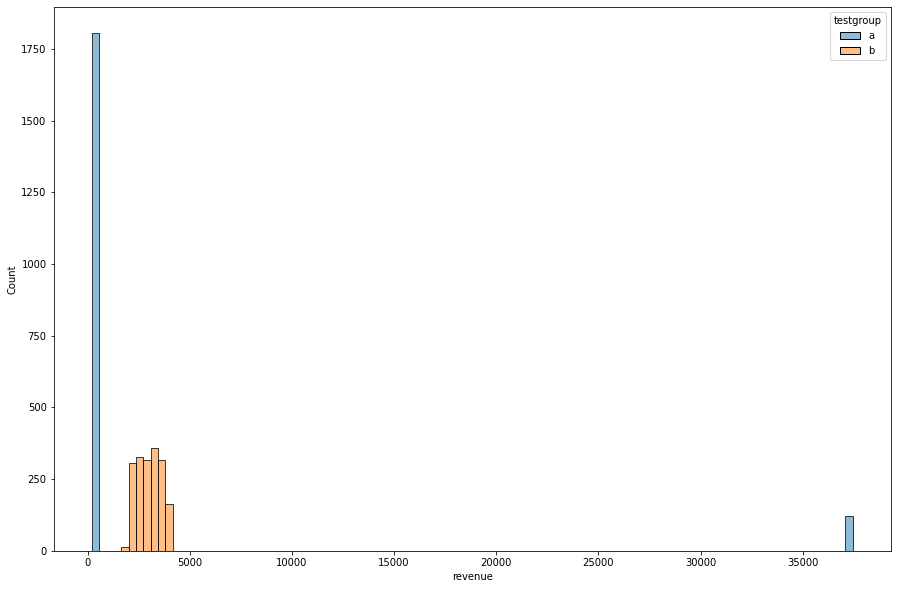

In [15]:
# Посмотрим на распределение выручки по группам и отфильтруемся только по платящим пользователям
plt.figure(figsize=(15,10))
sns.histplot(data = df[df['revenue'] != 0], x = 'revenue', hue = 'testgroup')

По гистограмме видно, что для тестовой группы основная масса выручки у пользователей сконцентрировалась в диапазоне от ~2000 до ~5000. А для контрольной группы от 0 до ~1000. И, есть некоторые пользователи, выручка от которых превышает 35000

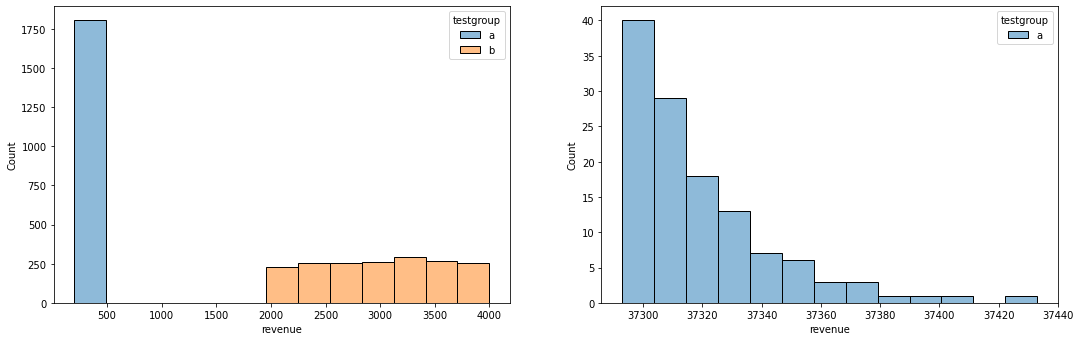

In [16]:
plt.figure(figsize=(18,12))
plt.subplot(2, 2, 1)
sns.histplot(data = df[(df['revenue'] > 0) & (df['revenue'] < 5000)], x = 'revenue', hue = 'testgroup')

plt.subplot(2, 2, 2)
sns.histplot(data = df[df['revenue'] > 35000], x = 'revenue', hue = 'testgroup')

In [17]:
a_under_500 = df.query("testgroup == 'a' & (revenue > 0 & revenue < 500)").shape[0]
a_higher_37000 = df.query("testgroup == 'a' & revenue > 35000").shape[0]

b_2000_4000 = df.query("testgroup == 'b' & (revenue > 1500 & revenue < 5000)").shape[0]

# Вывод результатов
print("Количество юзеров в контрольной группе, с выручкой до 500:", a_under_500)
print("Количество юзеров в контрольной группе, с выручкой более чем 37000:", a_higher_37000)
print("Количество юзеров в тестовой группе, с выручкой в диапазоне 2000-4000:", b_2000_4000)

Количество юзеров в контрольной группе, с выручкой до 500: 1805
Количество юзеров в контрольной группе, с выручкой более чем 37000: 123
Количество юзеров в тестовой группе, с выручкой в диапазоне 2000-4000: 1805


Посмотрим через boxplot есть ли выбросы в данных

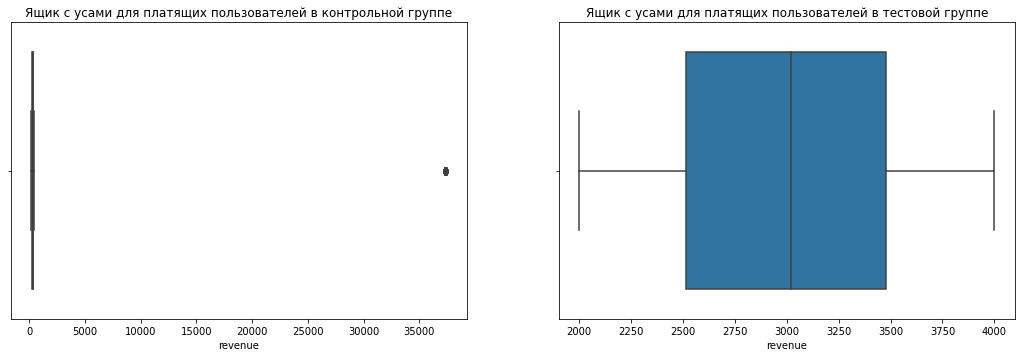

In [18]:
plt.figure(figsize=(18,12))
plt.subplot(2, 2, 1)
plt.title('Ящик с усами для платящих пользователей в контрольной группе')
sns.boxplot(data = df.query("testgroup == 'a' & revenue > 0"), x = 'revenue')

plt.subplot(2, 2, 2)
plt.title('Ящик с усами для платящих пользователей в тестовой группе')
sns.boxplot(data = df.query("testgroup == 'b' & revenue > 0"), x = 'revenue')

Из проведенного анализа, можно сделать вывод, что в контрольной группе из 1928 платящих пользователей 93,6% приходится на пользователей с выручкой до 500. А 6,4% пользователей (123 человека) принесли выручку более чем 37000. После построения ящика с усами для выручки в контрольной группе обнаружилось, что эти данные относятся к выбросам.

В тестовой же группе таких "выбросов" нет и все платящие пользователи расположились в диапазоне выручки от 2000 до 4000.

--------------

### Прежде чем формулировать и проверять гипотезы подготовим данные таким образом, чтобы рассчитать интересующие нас метрики. Напишем функцию, в которой будут рассчитываться метрики Average Revenue Per User (ARPU), Average Revenue Per Paying User (ARPPU), Conversion Rate (CR)

In [19]:
def metrics_df(df):
    total_users = df.groupby('testgroup', as_index = False) \
               .agg({'user_id' : 'nunique'}) \
               .rename(columns = {'user_id' : 'total_users'})
    
    paying_users = df.query("revenue > 0") \
                     .groupby('testgroup', as_index = False) \
                     .agg({'user_id' : 'nunique'}) \
                     .rename(columns = {'user_id' : 'paying_users'})
    
    revenue_df = df.groupby('testgroup').agg({'revenue' : 'sum'})
    
    metrics_df = total_users.copy()
    metrics_df = metrics_df.merge(paying_users, how = 'left', on = 'testgroup')
    metrics_df = metrics_df.merge(revenue_df, how = 'left', on = 'testgroup')
    
    metrics_df['ARPU'] = round(metrics_df['revenue'] / metrics_df['total_users'], 2)
    metrics_df['ARPPU'] = round(metrics_df['revenue'] / metrics_df['paying_users'], 2)
    metrics_df['CR'] = round(metrics_df['paying_users'] / metrics_df['total_users'] * 100, 2)
    
    return metrics_df

In [20]:
task_2 = metrics_df(df)
task_2

,testgroup,total_users,paying_users,revenue,ARPU,ARPPU,CR
0,a,202103,1928,5136189,25.41,2664.00,0.95
1,b,202667,1805,5421603,26.75,3003.66,0.89


In [21]:
arpu_a = task_2.loc[task_2['testgroup'] == 'a', 'ARPU'].values[0]
arpu_b = task_2.loc[task_2['testgroup'] == 'b', 'ARPU'].values[0]

arpu_b / arpu_a * 100

105.27351436442345

### **Общая выручка по группам составила:**
    - В контрольной группе: 5 136 189;
    - В тестовой группе: 5 421 603.
### **ARPU по группам:**
    - В контрольной группе: 25.41;
    - В тестовой группе: 26.75.
    Также проверили, что судя по полученным данным, рост ARPU в тестовой группе действительно составляет 5% 
    относительно контрольной.
### **ARPPU по группам:**
    - В контрольной группе: 2664.00;
    - В тестовой группе: 3003.66.
### **CR по группам:**
    - В контрольной группе: 0.95;
    - В тестовой группе: 0.89.

Теперь необходимо определить, есть ли статистически значимые различия между группами по исследуемым ключевым метрикам. 
В первую очередь данные необходимо проверить на нормальность распределения. Для решения этой задачи буду использовать тест Шапиро-Уилка. Проверку равенства дисперсий между группами произведу при помощи теста Левена. 

In [22]:
# Проверка на нормальность распределения выручки в каждой группе
shapiro_a = sps.shapiro(df.query("testgroup == 'a'")['revenue'])
shapiro_b = sps.shapiro(df.query("testgroup == 'b'")['revenue'])

shapiro_a, shapiro_b

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(ShapiroResult(statistic=0.008876502513885498, pvalue=0.0),
 ShapiroResult(statistic=0.06588172912597656, pvalue=0.0))

In [23]:
# Проверка на равенство дисперсий
levene_test = sps.levene(df.query("testgroup == 'a'")['revenue'], df.query("testgroup == 'b'")['revenue'])

levene_test

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Результаты теста на нормальность распределения данных показали свидетельствуют о том, что распределение данных не является нормальным. 

В таком случае для сравнения различий между группами применяются непараметрические тесты, например U-критерий Манна-Уитни? однако, для выборки такого размера допускается использовать и T-test поэтому при сравнении ARPU и ARPPU я буду использовать его.

Для определения различий в конверсиях между двумя группами буду использовать Хи-Квадрат.

### Для сравнения `ARPU` сформулируем проверяемые гипотезы следующим образом:

- $H_0$: ARPU в группах не отличаются
- $H_1$: отличия есть

In [24]:
# Выполнение t-test
statistic, p_value = sps.ttest_ind(df.query("testgroup == 'a'")['revenue'], df.query("testgroup == 'b'")['revenue'])

# Вывод результатов
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: -0.6242026493616787
p-value: 0.532494858971837


#### Получившееся `p-value > 0.05`, поэтому гипотеза $H_0$ не отклоняется.

-----

### Для сравнения `ARPPU` сформулируем проверяемые гипотезы следующим образом:

- $H_0$: ARPPU в группах не отличаются
- $H_1$: отличия есть

In [25]:
# Выполнение t-test
statistic, p_value = sps.ttest_ind(df.query("testgroup == 'a' & revenue != 0")['revenue'], 
                                   df.query("testgroup == 'b' & revenue != 0")['revenue'])
# Вывод результатов
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: -1.5917100176862002
p-value: 0.11153459157259504


#### Получившееся `p-value > 0.05`, поэтому гипотеза $H_0$ не отклоняется.

-----------------------------------------

### Для сравнения `CR` сформулируем проверяемые гипотезы следующим образом:

- $H_0$: CR в группах не отличаются
- $H_1$: отличия есть

In [27]:
df['converted'] = df['revenue'].apply(lambda x: 1 if x > 0 else 0)

In [28]:
cross_tab = pd.crosstab(df['testgroup'], df['converted'])
cross_tab

converted,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [29]:
# Применение теста хи-квадрат
stat, p_value, dof, expected = sps.chi2_contingency(cross_tab)

# Вывод результатов
print("Statistic:", stat)
print("p-value:", p_value)

Statistic: 4.374729521260405
p-value: 0.03647561892312613


#### `p-value < 0.05` , поэтому следует отклонить $H_0$ и принять $H_1$.

-------

## Выводы:

1. На основе результатов сравнения ARPU и ARPPU с использованием t-test в контрольной и тестовой группах можно сделать вывод о том, что статистически значимых различий в группах между двумя этими метриками не обнаружено, даже не смотря на то, что визуально ARPU в тестовой группе выше на 5%.
 
2. Применение хи-квадрат позволил удостовериться в том, что CR в контрольной группе выше, чем в тестовой.

--------

## Задание 3.
## Общее описание:
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

- DAU/MAU (позволят оценить дневную/месячную активность пользователей во время ивента и сравнить показатели с показателями когда ивент не проводится).


- Доля участников ивента (сколько юзеров от общего числа MAU учавствует в ивенте).


- Retention rate/churn rate (позволит оценить удержание и отток пользователей и понять нравится ли ивент или нет).


- Среднее время нахождения в онлайне в течение месяца (позволит оценить как выросло время, которое проводят в игре пользователи после введения ивента).


- Средний прогресс левела (позволит более точно установить ценность для наград за уровни. За первые уровни даются не слишком ценные предметы, по мере нарастания уровней ценность предметов повышается. Эта метрика позволит определить до какого уровня в среднем дошли наши юзеры).


- Среднее время прохождения и количество попыток чтобы пройти уровень (позволит оценить сложность уровней).


- Если существует магазин внутриигровых предметов за донат, то можно сравнить выручку в течение ивента с выручкой в период когда ивент не проводится.


----
- Думаю, что в случае усложнения механики ивента оцениваемые метрики не изменятся. Нам особенно важно оценивать DAU/MAU, retention и churn rate, т к усложненная механика событий может негативно повлиять на число активных юзеров.
